In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from lightgbm import LGBMClassifier 
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,BaggingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.plotting import plot_decision_regions
import dtreeviz as dtvz
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("F:/dataset_for_ML/Ensemble Learning/classification/adultIncomePrediction.csv")

In [3]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [5]:
df.duplicated().sum()

24

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.columns,df.shape

(Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
        'marital.status', 'occupation', 'relationship', 'race', 'sex',
        'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
        'income'],
       dtype='object'),
 (32537, 15))

In [8]:
df.sample(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
26659,63,?,106648,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,25,United-States,<=50K
20508,35,Private,166606,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K
29836,30,Private,178587,Assoc-voc,11,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States,<=50K
19956,23,Private,212888,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
21793,25,Private,71351,1st-4th,2,Never-married,Other-service,Other-relative,White,Male,0,0,25,El-Salvador,<=50K
13155,20,Private,238685,Some-college,10,Never-married,Sales,Not-in-family,White,Female,0,0,30,United-States,<=50K
495,54,Self-emp-not-inc,109418,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,1977,35,United-States,>50K
4886,37,Private,103408,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,0,0,40,United-States,<=50K
29801,32,Self-emp-not-inc,35595,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
8759,21,Private,209483,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K


1) for workclass, those workclass below 1000, replace with the value others 
2) For education, we already have a label feature named education.num 
3) same for marital.status as workclass, for below valuecounts of 1000, we will replace it with others 
4) same as number 3 and number 1. for occupation
5) for native county, we will do the same as number 1,3 and 4. i.e. use one-hot-encoding and classify it as others.
6) We have question mark data on two columns, workforce and occupation !  

In [9]:

# df["marital.status"].value_counts()
# df["occupation"].value_counts()
# df["relationship"].value_counts()
# df["capital.gain"].value_counts()
# df["native.country"].value_counts()
# df["income"].value_counts()
# df["hours.per.week"].value_counts().values

<!-- here, the income is divided into lessthan or equals to 50, and greater than 50, we will just use 0 and 1 , as like in normal classification!  -->

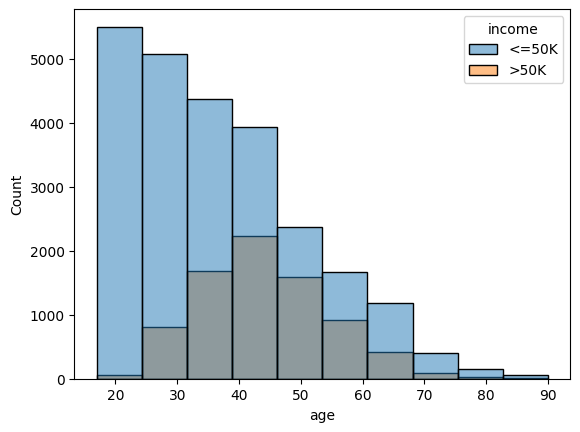

In [10]:
sns.histplot(x=df['age'],hue=df["income"],bins=10)
plt.show()

<Axes: xlabel='fnlwgt', ylabel='age'>

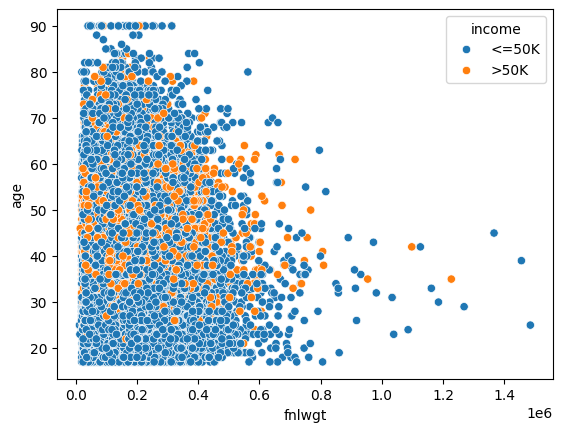

In [11]:
sns.scatterplot(x=df["fnlwgt"],y=df["age"],hue=df["income"])

In [12]:
df["fnlwgt"].describe(include="all")

count    3.253700e+04
mean     1.897808e+05
std      1.055565e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.369930e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

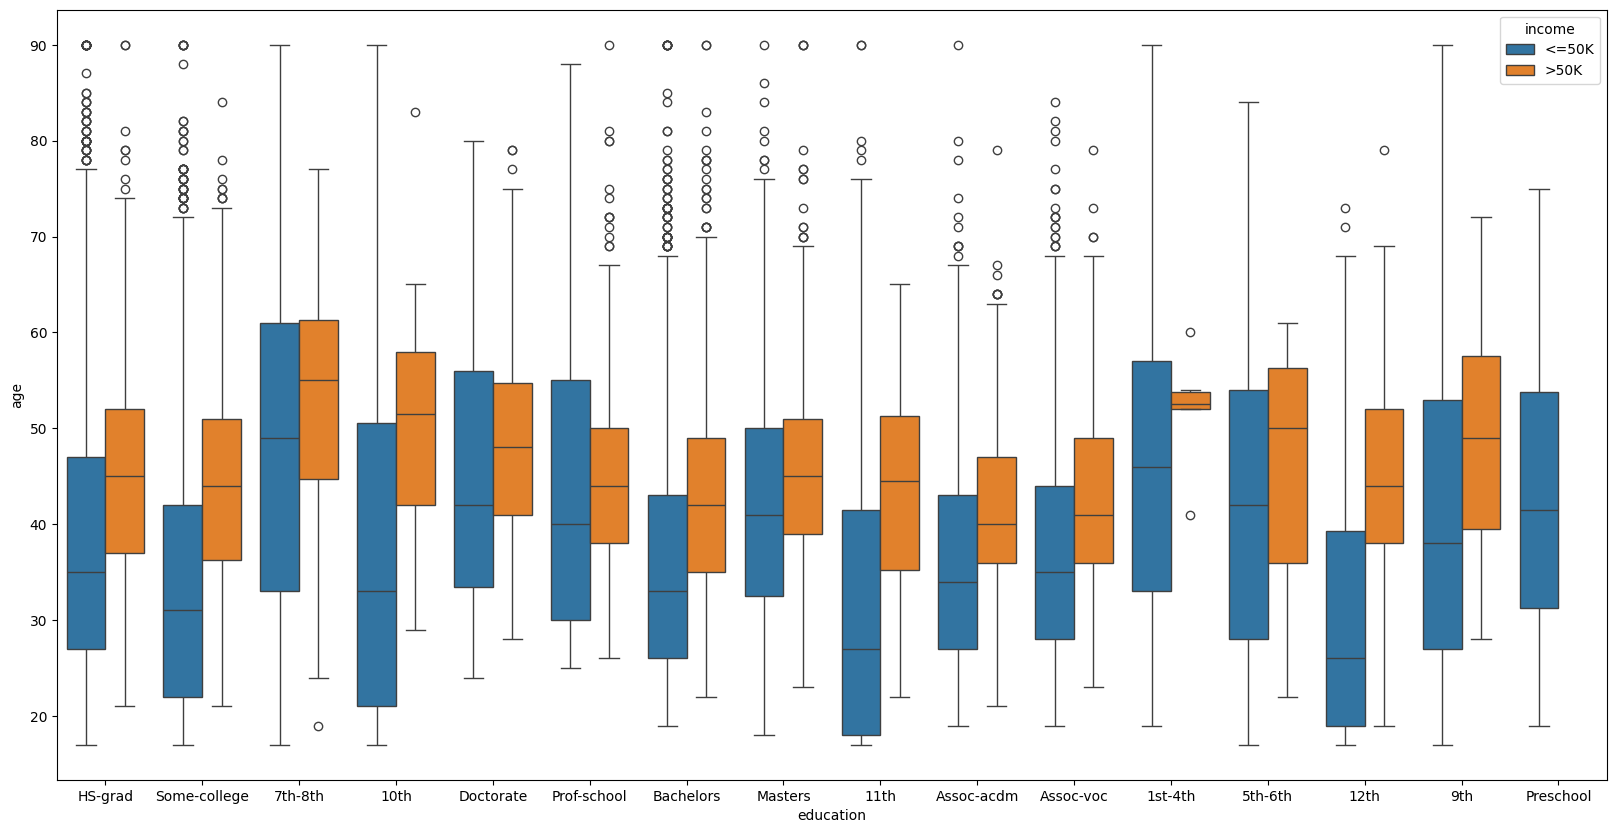

In [13]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df,y="age",x="education",hue="income")
plt.show()

In [14]:
df['marital.status'].value_counts().values

array([14970, 10667,  4441,  1025,   993,   418,    23], dtype=int64)

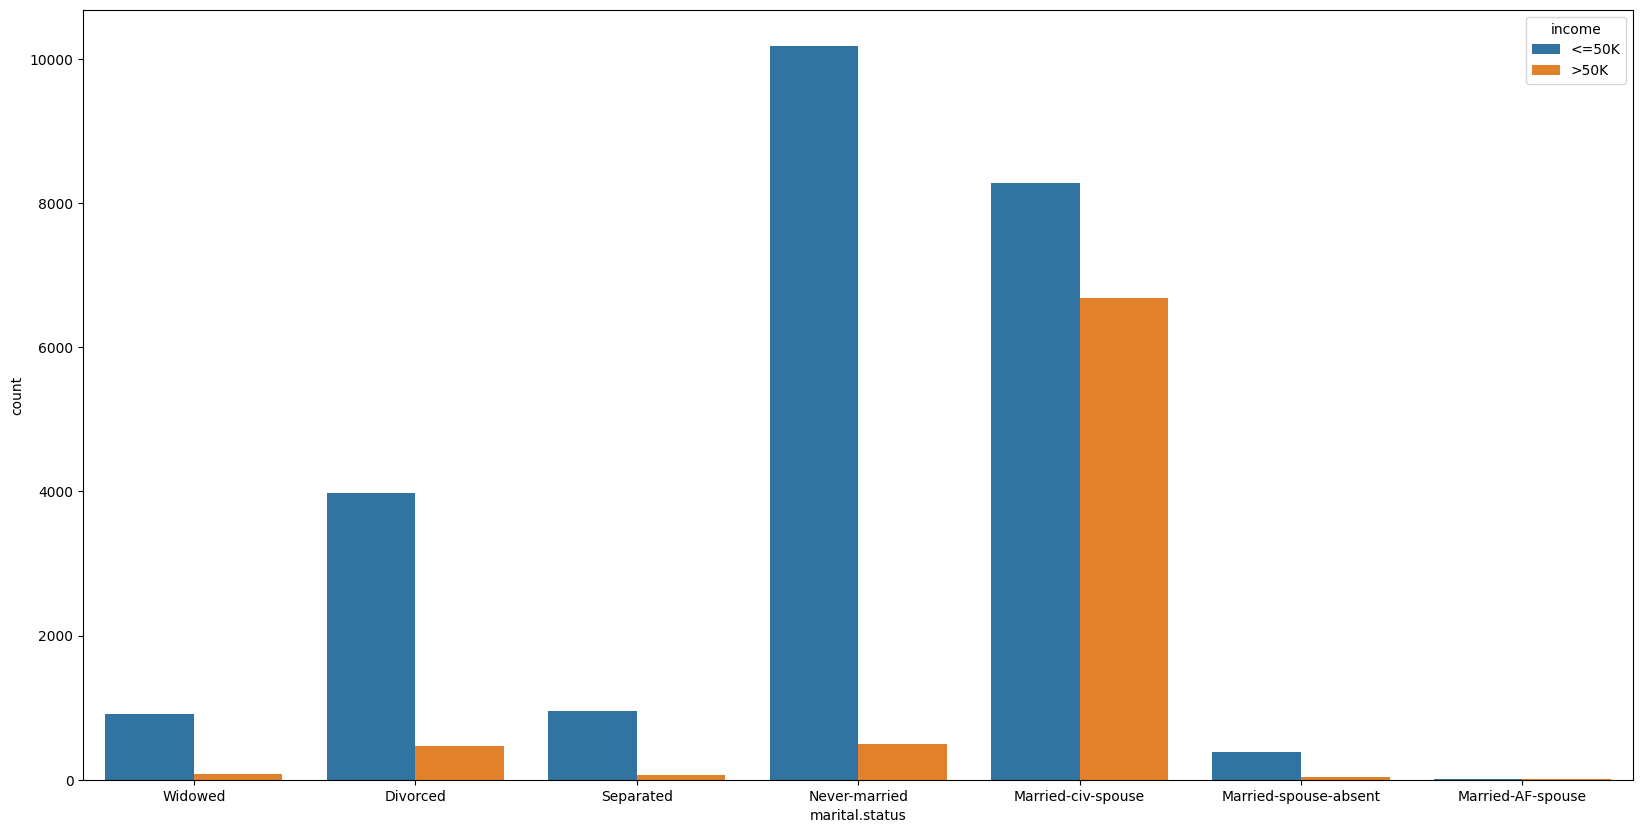

In [15]:
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='marital.status',hue="income")
plt.show()

<Axes: xlabel='age', ylabel='Count'>

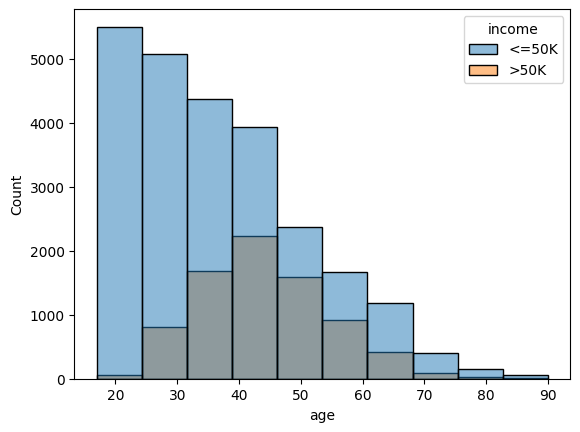

In [16]:
sns.histplot(data=df,x="age",bins=10,hue="income")

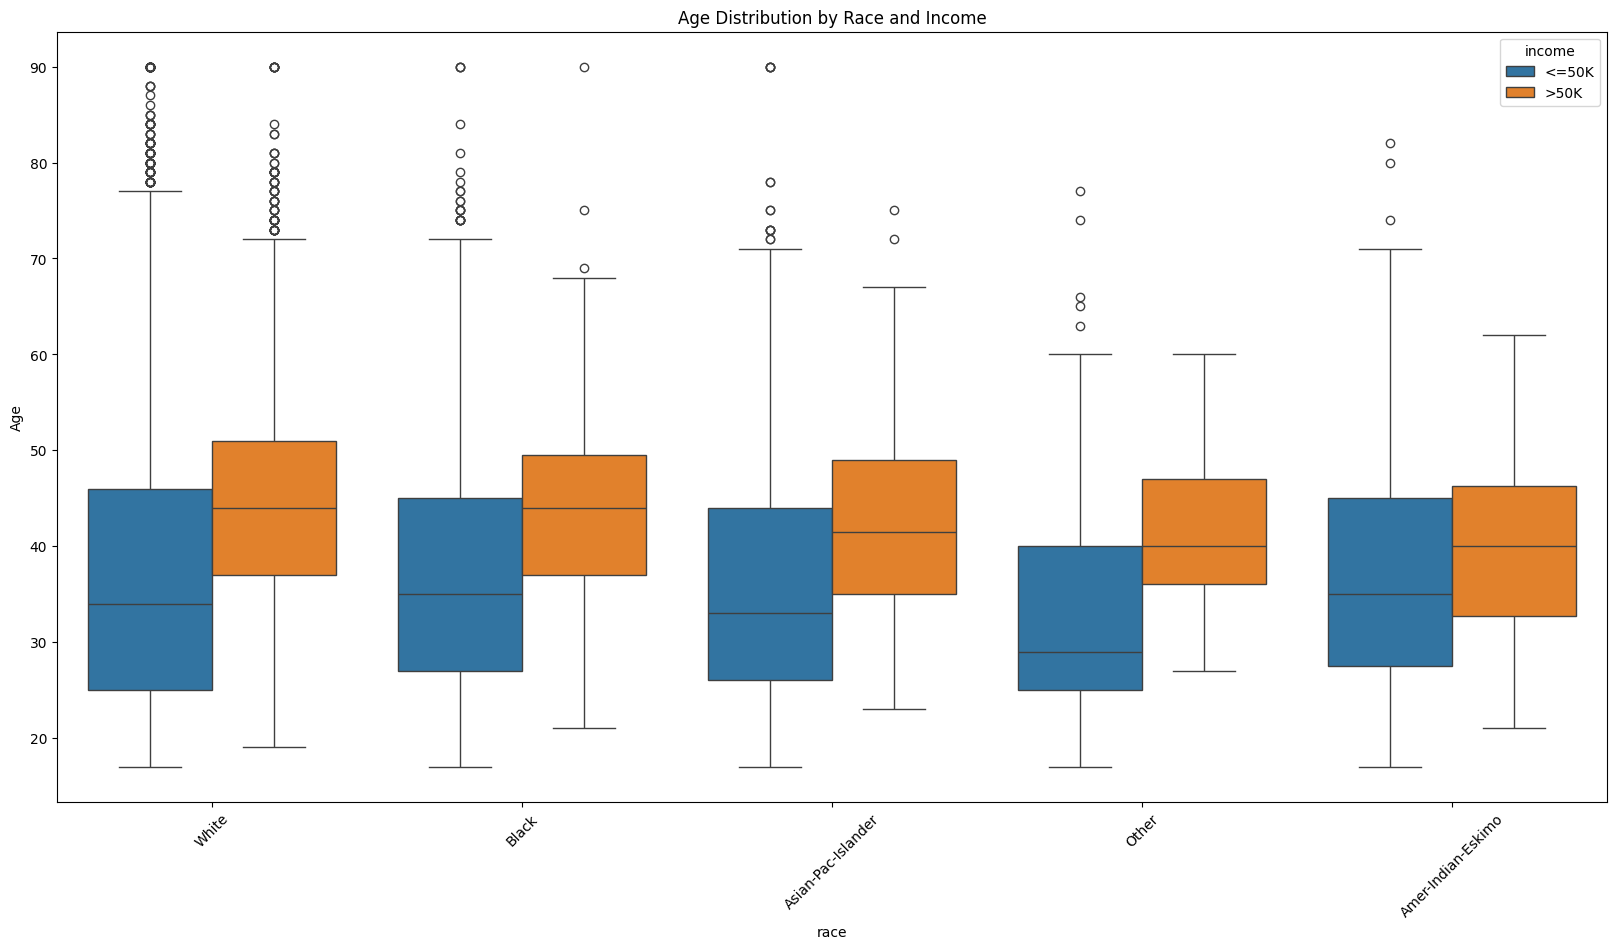

In [17]:
plt.figure(figsize=(20,10))
sns.boxplot(x='race', y='age', hue='income', data=df)
plt.xticks(rotation=45)
plt.title("Age Distribution by Race and Income")
plt.ylabel("Age")
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_13600\928673097.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
C:\Users\DELL\AppData\Local\Temp\ipykernel_13600\928673097.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


<Figure size 2000x1000 with 0 Axes>

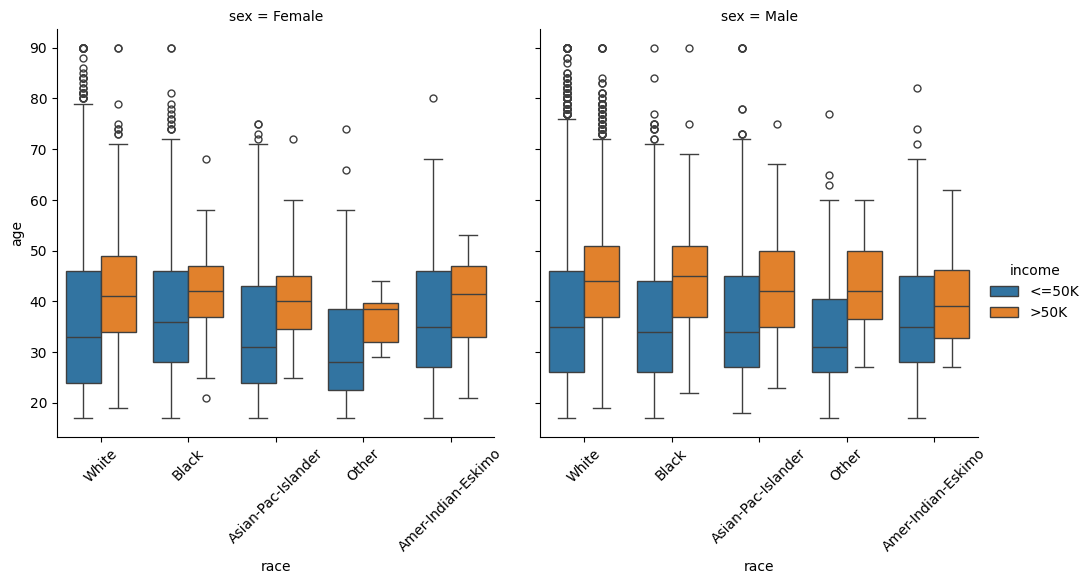

In [18]:
plt.figure(figsize=(20,10))
g = sns.catplot(
    data=df,
    x="race",
    y="age",
    kind="box",  
    hue="income",  
    # row="sex",    
    col="sex",    
)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [19]:
df["age"].describe()

count    32537.000000
mean        38.585549
std         13.637984
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [20]:
X = df.iloc[:,:-1]
y = df["income"]

In [21]:
undersampler = RandomUnderSampler()
X,y = undersampler.fit_resample(X,y)

In [22]:
X.shape,y.shape

((15678, 14), (15678,))

In [23]:
df["native.country"].value_counts()

native.country
United-States                 29153
Mexico                          639
?                               582
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        62
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece       

In [24]:
imputer = SimpleImputer(missing_values="?",strategy="most_frequent")

In [25]:
X[["workclass","occupation","native.country"]]= imputer.fit_transform(X[["workclass","occupation","native.country"]])

In [26]:
X

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
22138,68,Private,351402,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,70,United-States
8638,24,State-gov,165201,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,45,United-States
7814,30,Private,219838,12th,8,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States
23153,20,Private,258430,Some-college,10,Never-married,Other-service,Own-child,White,Female,0,0,19,United-States
11191,45,Private,189802,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32539,34,Private,160216,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,55,United-States
32541,71,Private,287372,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,10,United-States
32547,39,Local-gov,111499,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States


In [27]:
# workforce, marital.status,occupation,native.country 

In [28]:
def downsizingTheCatCols(temp_df,columns,threshold=1000):
    for col in columns:
        # print(col)
        # print(temp_df[col])
        if col == "native.country":
            # print("Column name",col)
            threshold=100
            # print(threshold)

        value_counts=temp_df[col].value_counts()
        # print(threshold)
        rare_categories = value_counts[value_counts<threshold].index
        # print(rare_categories)
        temp_df[col] = temp_df[col].apply(lambda x: 'Other' if x in rare_categories else x)

    return temp_df
        

        

In [29]:
X = downsizingTheCatCols(X,["workclass","marital.status","occupation","native.country"])

In [30]:
# X["workclass"].value_counts()
# X["native.country"].value_counts()
# X["occupation"].value_counts()
# X["workclass"].value_counts()
# X["workclass"].value_counts()

##### here, in occupation, others and other-services will be treated differently

## NOW, we will use encoder and feature scaling for dataset, 

In [31]:
X.drop(columns="education",inplace=True)

In [32]:
X["education.num"].value_counts()

education.num
9     4494
10    3238
13    3206
14    1221
11     695
12     519
15     469
7      419
16     342
6      326
4      226
8      160
5      156
3      131
2       61
1       15
Name: count, dtype: int64

In [33]:
X.columns

Index(['age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
       'occupation', 'relationship', 'race', 'sex', 'capital.gain',
       'capital.loss', 'hours.per.week', 'native.country'],
      dtype='object')

In [34]:
num_cols = ["age","fnlwgt","capital.gain","capital.loss","hours.per.week"]
one_hot_cols = ["workclass","marital.status","occupation","relationship","sex","race","native.country"]

In [35]:
standard_scaling_ppl = Pipeline(
    steps=[
        ("standardScalingInNumericalcols",StandardScaler())
    ]
)
one_hot_encoding_ppl = Pipeline(
    steps=[
        ("OneHotEncodingForCatCols",OneHotEncoder(drop="first",sparse_output=True,handle_unknown="ignore"))
    ]
)

In [36]:
preprocessing = ColumnTransformer(
    transformers=[
        ("SS",standard_scaling_ppl,num_cols),
        ("ohe",one_hot_encoding_ppl,one_hot_cols)
    ],
    remainder="passthrough",
    n_jobs=-1
)

In [37]:
preprocessing

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('SS',
                                 Pipeline(steps=[('standardScalingInNumericalcols',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('ohe',
                                 Pipeline(steps=[('OneHotEncodingForCatCols',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'relationship', 'sex', 'race',
                                  'native.country'])])

In [38]:
lbl_enoder = LabelEncoder()
y = lbl_enoder.fit_transform(y)

In [39]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.2)

First using Decision Tree Classifier

In [41]:
param_grid = {
    "dtc_model__max_depth" : [None,2,3,5,10],
    "dtc_model__criterion" : ["gini","entropy","log_loss"],
    "dtc_model__min_samples_split" : [None,2,3,5],
    "dtc_model__min_samples_leaf" : [None,2,3,5],
    "dtc_model__max_features" : [None,2,3,5,8]
}

In [42]:
dtc_ppl = Pipeline(steps=[
    ("preprocessing",preprocessing),
    ("dtc_model",DecisionTreeClassifier(random_state=42))
])

In [43]:
dtc_model_estimator = GridSearchCV(estimator=dtc_ppl,param_grid=param_grid,scoring="accuracy",cv=5,verbose=True,n_jobs=-1)

In [44]:
dtc_model_estimator.fit(X_train,y_train)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2625 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\skle

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('SS',
                                                                         Pipeline(steps=[('standardScalingInNumericalcols',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        hand...
                                                                          'native.country'])])),
                                       ('dtc_model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'dtc_model__criterion': ['gini', 'entropy',
                                                  'log_loss'],
                         'dtc_model__max_depth': [None, 2, 3, 5, 10],
                         'dtc_model__max_features': [None, 2, 3, 5, 8],
                         'dtc_model__min_samples_leaf': [None, 2, 3, 5],
                         'dtc_model__min_samples_split': [None, 2, 3, 5]},
             scoring='accuracy', verbose=True)

In [45]:
dtc_model_estimator.best_params_,dtc_model_estimator.best_score_

({'dtc_model__criterion': 'entropy',
  'dtc_model__max_depth': 10,
  'dtc_model__max_features': None,
  'dtc_model__min_samples_leaf': 3,
  'dtc_model__min_samples_split': 2},
 0.8211603458808259)

In [46]:
dtc_model = DecisionTreeClassifier(criterion="entropy",max_depth=10,max_features=None,min_samples_leaf=2,min_samples_split=2)

In [47]:
best_dtc_model_ppl = Pipeline(
    steps=[
        ("preprocessing",preprocessing),
        ("bestDTCCModel",dtc_model)
    ]
)

In [48]:
best_dtc_model_ppl.fit(X_train,y_train)

c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('SS',
                                                  Pipeline(steps=[('standardScalingInNumericalcols',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('ohe',
                                                  Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'sex', 'race',
                                                   'native.country'])])),
                ('bestDTCCModel',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=2))])

In [49]:
dtc_model_pred = best_dtc_model_ppl.predict(X_test)

In [50]:
y_test

array([1, 0, 0, ..., 0, 0, 1])

In [51]:
accuracy_score(dtc_model_pred,y_test),recall_score(dtc_model_pred,y_test),f1_score(dtc_model_pred,y_test),precision_score(dtc_model_pred,y_test)

(0.8073979591836735,
 0.7785388127853882,
 0.8187274909963985,
 0.8632911392405064)

[Text(0.6177734375, 0.9545454545454546, 'x[8] <= 0.5\nentropy = 1.0\nsamples = 12542\nvalue = [6283.0, 6259.0]'),
 Text(0.3796614583333333, 0.8636363636363636, 'x[2] <= 0.255\nentropy = 0.675\nsamples = 5123\nvalue = [4212, 911]'),
 Text(0.49871744791666667, 0.9090909090909092, 'True  '),
 Text(0.24265625, 0.7727272727272727, 'x[30] <= 12.5\nentropy = 0.573\nsamples = 4852\nvalue = [4193, 659]'),
 Text(0.11854166666666667, 0.6818181818181818, 'x[0] <= -0.936\nentropy = 0.368\nsamples = 3722\nvalue = [3459, 263]'),
 Text(0.04083333333333333, 0.5909090909090909, 'x[3] <= 4.11\nentropy = 0.098\nsamples = 1578\nvalue = [1558, 20]'),
 Text(0.0375, 0.5, 'x[4] <= 0.19\nentropy = 0.086\nsamples = 1575\nvalue = [1558, 17]'),
 Text(0.016666666666666666, 0.4090909090909091, 'x[1] <= -1.522\nentropy = 0.046\nsamples = 1372\nvalue = [1365.0, 7.0]'),
 Text(0.006666666666666667, 0.3181818181818182, 'x[0] <= -1.324\nentropy = 0.575\nsamples = 22\nvalue = [19, 3]'),
 Text(0.0033333333333333335, 0.22727

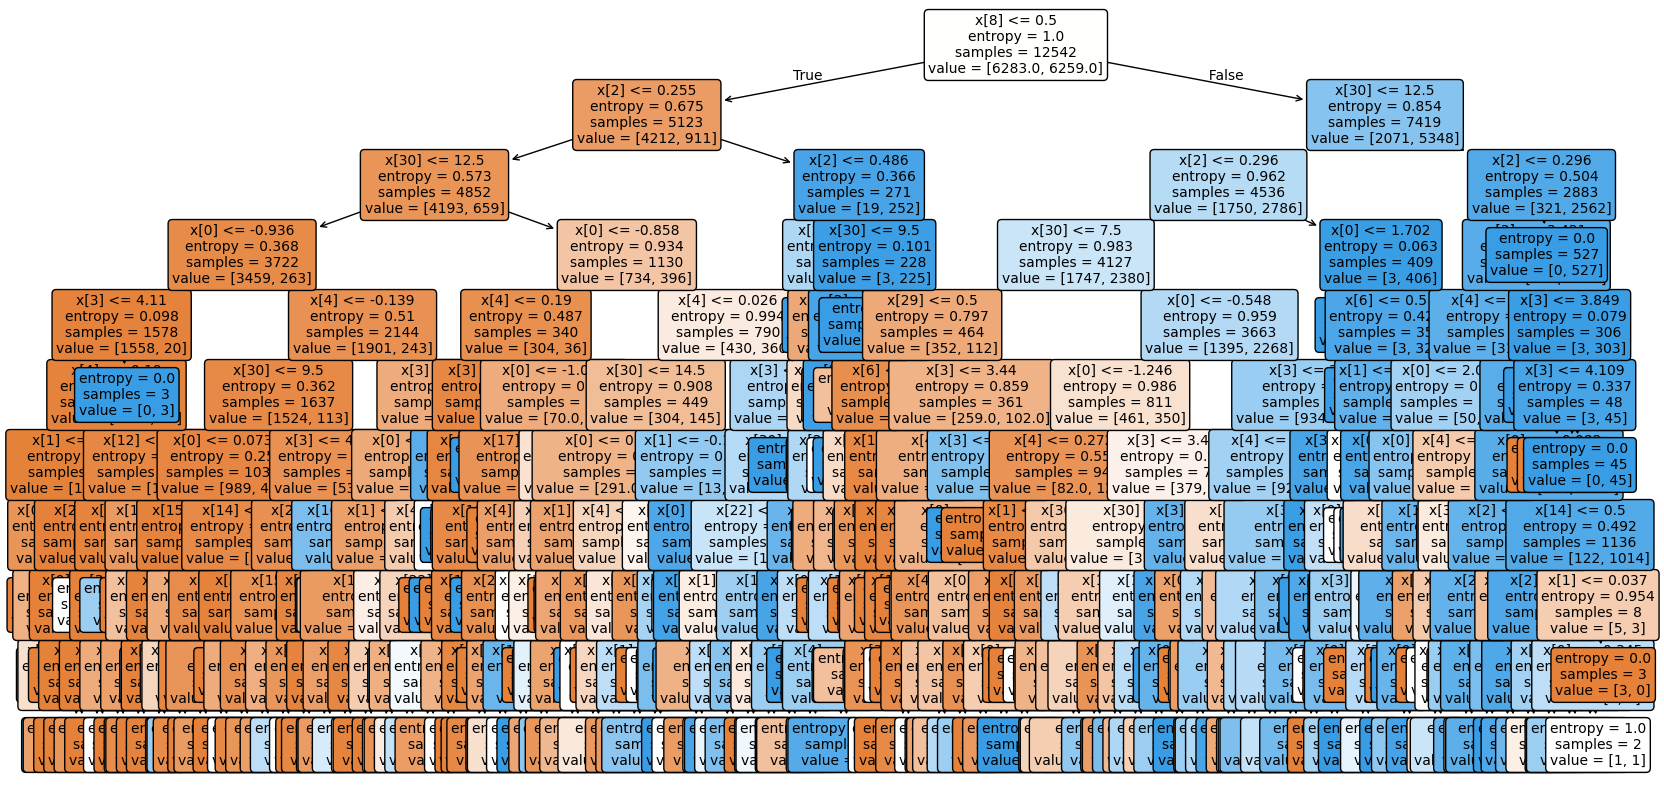

In [52]:
plt.figure(figsize=(20, 10))
plot_tree(
    dtc_model,
    filled=True,
    rounded=True,
    fontsize=10
)

In [53]:
##############     THIS IS DONE FOR TRANSFORMING THE DATA SEPARATELY. THE THING IS , PIPELINING CANNOT BE USED IN THE GRAPH PLOTTING.

# X_trans = best_dtc_model_ppl.named_steps["preprocessing"].transform(X)
# X_test_trans = best_dtc_model_ppl.named_steps["preprocessing"].transform(X_test)
# model = best_dtc_model_ppl.named_steps["bestDTCCModel"]

In [54]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_trans)


In [55]:
# model.fit(X_pca, y)
# plot_decision_regions(X_pca, y, clf=model, legend=2)
# plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('Decision Regions (PCA)')
# plt.show()

In [56]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(criterion="entropy",max_depth=10,max_features=None,min_samples_leaf=2,min_samples_split=2,random_state=42),
    random_state=42
)

In [57]:
bagging_clf_pipeline = Pipeline(steps=[
    ("preprocessing",preprocessing),
    ("bagging_clf",bagging_clf)
])

In [58]:
bagging_clf_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('SS',
                                                  Pipeline(steps=[('standardScalingInNumericalcols',
                                                                   StandardScaler())]),
                                                  ['age', 'fnlwgt',
                                                   'capital.gain',
                                                   'capital.loss',
                                                   'hours.per.week']),
                                                 ('ohe',
                                                  Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['workclass',
                                                   'marital.status',
                                                   'occupation', 'relationship',
                                                   'sex', 'race',
                                                   'native.country'])])),
                ('bagging_clf',
                 BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                    max_depth=10,
                                                                    min_samples_leaf=2,
                                                                    random_state=42),
                                   random_state=42))])

In [59]:
param_grid = {
    'bagging_clf__n_estimators': [None,2,5,10], 
    'bagging_clf__max_samples': [None,0.3, 0.5,0.7, 1.0], 
    'bagging_clf__max_features': [None,0.3,0.5, 0.7, 1.0],  
    'bagging_clf__bootstrap':[True,False],
    'bagging_clf__oob_score':[True,False]
    
}

In [60]:
gridSearch_bagging_clf_dtc = GridSearchCV(bagging_clf_pipeline,param_grid,cv=5,n_jobs=-1)

In [61]:
gridSearch_bagging_clf_dtc.fit(X_train,y_train)

c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1280 fits failed out of a total of 2000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
400 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('SS',
                                                                         Pipeline(steps=[('standardScalingInNumericalcols',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        hand...
                                        BaggingClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                           max_depth=10,
                                                                                           min_samples_leaf=2,
                                                                                           random_state=42),
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'bagging_clf__bootstrap': [True, False],
                         'bagging_clf__max_features': [None, 0.3, 0.5, 0.7,
                                                       1.0],
                         'bagging_clf__max_samples': [None, 0.3, 0.5, 0.7, 1.0],
                         'bagging_clf__n_estimators': [None, 2, 5, 10],
                         'bagging_clf__oob_score': [True, False]})

In [62]:
print(gridSearch_bagging_clf_dtc.best_params_),print(gridSearch_bagging_clf_dtc.best_score_)

{'bagging_clf__bootstrap': True, 'bagging_clf__max_features': 1.0, 'bagging_clf__max_samples': 0.5, 'bagging_clf__n_estimators': 10, 'bagging_clf__oob_score': True}
0.8281772222868486


(None, None)

In [63]:
pred = gridSearch_bagging_clf_dtc.predict(X_test)

In [64]:
accuracy_score(pred,y_test),recall_score(pred,y_test),precision_score(pred,y_test),f1_score(pred,y_test)

(0.8191964285714286,
 0.7919308357348703,
 0.8696202531645569,
 0.8289592760180996)

USING LOGISTIC REGRESSION !

In [65]:
lr = LogisticRegression()

In [66]:
lr_ppl = Pipeline(steps=[
    ("preprocessing",preprocessing),
    ("lr",lr)
])

In [67]:
param_dist = {
    'lr__penalty': ['l1', 'l2', 'elasticnet'],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__max_iter': [100, 200, 500, 1000]
}

In [68]:
grid_srch_lr_ppl = GridSearchCV(lr_ppl,param_dist,cv=5,scoring="accuracy",n_jobs=-1)

In [69]:
grid_srch_lr_ppl.fit(X_train,y_train)

c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
160 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('SS',
                                                                         Pipeline(steps=[('standardScalingInNumericalcols',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['workclass',
                                                                          'marital.status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'sex',
                                                                          'race',
                                                                          'native.country'])])),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__max_iter': [100, 200, 500, 1000],
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                        'sag', 'saga']},
             scoring='accuracy')

In [70]:
grid_srch_lr_ppl.best_params_,grid_srch_lr_ppl.best_score_

({'lr__max_iter': 100, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'},
 0.8193267872024348)

In [71]:
pred = grid_srch_lr_ppl.predict(X_test)

In [72]:
print(accuracy_score(pred,y_test)),print(recall_score(pred,y_test)),print(f1_score(pred,y_test)),print(precision_score(pred,y_test))

0.8128188775510204
0.7943094250148192
0.8203244566880931
0.8481012658227848


(None, None, None, None)

In [73]:
lr_bagging_classifier = BaggingClassifier(
    estimator=LogisticRegression(max_iter=500,penalty='l1',solver='saga'),
    n_jobs=-1,
    random_state=42,
    bootstrap=True
)

In [74]:
lr_bagging_classifier_ppl = Pipeline(steps=[
    ("preprocessing",preprocessing),
    ("lr_bagging_classifier",lr_bagging_classifier)
])

In [75]:
param_grid_lr_bagging = {
    'lr_bagging_classifier__n_estimators': [None,2,5,10], 
    'lr_bagging_classifier__max_samples': [None,0.3, 0.5,0.7], 
    'lr_bagging_classifier__max_features': [None,0.3,0.5, 0.7],  
  
}

In [76]:
gridSearchForLrBagging = GridSearchCV(estimator=lr_bagging_classifier_ppl,n_jobs=-1,param_grid=param_grid_lr_bagging)

In [77]:
gridSearchForLrBagging.fit(X_train,y_train)

c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
185 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\DELL\.conda\envs\pandasNumpyMatplotlibPrac\lib\site-packages\sklearn\

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('SS',
                                                                         Pipeline(steps=[('standardScalingInNumericalcols',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fnlwgt',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('ohe',
                                                                         Pipeline(steps=[('OneHotEncodingForCatCols',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_un...
                                                                          'native.country'])])),
                                       ('lr_bagging_classifier',
                                        BaggingClassifier(estimator=LogisticRegression(max_iter=500,
                                                                                       penalty='l1',
                                                                                       solver='saga'),
                                                          n_jobs=-1,
                                                          random_state=42))]),
             n_jobs=-1,
             param_grid={'lr_bagging_classifier__max_features': [None, 0.3, 0.5,
                                                                 0.7],
                         'lr_bagging_classifier__max_samples': [None, 0.3, 0.5,
                                                                0.7],
                         'lr_bagging_classifier__n_estimators': [None, 2, 5,
                                                                 10]})

In [78]:
gridSearchForLrBagging.best_params_,gridSearchForLrBagging.best_score_

({'lr_bagging_classifier__max_features': 0.7,
  'lr_bagging_classifier__max_samples': 0.7,
  'lr_bagging_classifier__n_estimators': 2},
 0.8186888286697395)

In [79]:
pred_1 = gridSearchForLrBagging.predict(X_test)

In [80]:
print(accuracy_score(pred_1,y_test)),print(recall_score(pred_1,y_test)),print(f1_score(pred_1,y_test)),print(precision_score(pred_1,y_test))

0.8102678571428571
0.7832087406555491
0.8207291352817113
0.8620253164556962


(None, None, None, None)